In [2]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [3]:
file_path="my-dataset"
images = sorted(os.listdir(file_path + "/image"))
masks = sorted(os.listdir(file_path + "/mask"))

(3024, 4032, 3)


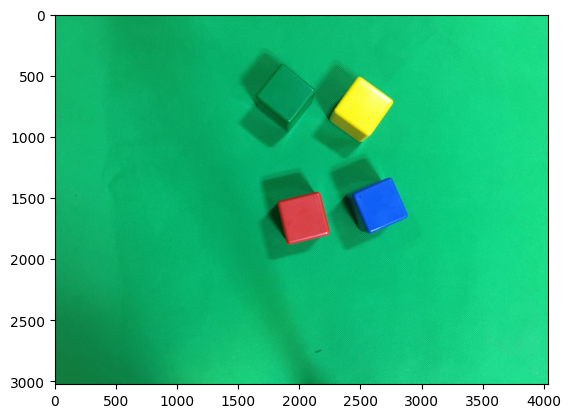

(4032, 3024, 1)


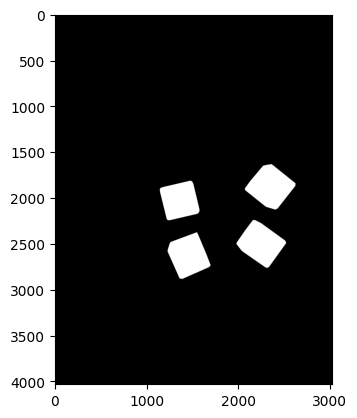

In [7]:
img_dir = file_path + '/image'
mask_dir = file_path + '/mask'
image_id = 100
img = images[image_id]

image = np.array(Image.open(os.path.join(img_dir, img)))
print(image.shape)
plt.imshow(image)
plt.show()

mask_image = np.array(Image.open(os.path.join(mask_dir, "mask_" + os.path.splitext(img)[0] + ".png")))
mask_image = np.expand_dims(mask_image, axis=-1)
print(mask_image.shape)
plt.imshow(mask_image, cmap="gray")
plt.show()

In [8]:
mask_image1 = mask_image[:, :, 0]
# for checking unique values in matrix
mask_image1[mask_image1 > 1] = 1
res = list(set(i for j in mask_image1 for i in j))
# printing result
print("Unique values in matrix are : " + str(res))

Unique values in matrix are : [0, 1]


In [9]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        self.images_name = sorted(os.listdir(file_path + "/image"))
        self.masks_name = sorted(os.listdir(file_path + "/mask"))

    def __getitem__(self , idx):
        img = Image.open(file_path + "/image/" + self.images_name[idx]).convert("RGB")
        mask = Image.open(file_path + "/mask/" + self.masks_name[idx])
        self.imgs = img
        mask = np.array(mask)
        mask = mask[:, :, 0]
        # for checking unique values in matrix
        mask[mask > 1] = 1
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        for i in range(num_objs):
            masks[i][mask == i+1] = True
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])
        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        masks = torch.as_tensor(masks , dtype = torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        return T.ToTensor()(img) , target

    def __len__(self):
        return len(self.images_name)

In [10]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

In [11]:
transform = T.ToTensor()

In [12]:
def custom_collate(data):
  return data

In [13]:
train_dl = torch.utils.data.DataLoader(CustDat("Internet-dataset/train") ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate,
                                 pin_memory = True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(CustDat("Internet-dataset/valid") ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate,
                                 pin_memory = True if torch.cuda.is_available() else False)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Internet-dataset/train/image'

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [89]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [90]:
params = [p for p in model.parameters() if p.requires_grad]

In [91]:
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [92]:
all_train_losses = []
all_val_losses = []
flag = False
for epoch in range(1):
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for i , dt in enumerate(train_dl):
        imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
        targ = [dt[0][1] , dt[1][1]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss = model(imgs , targets)
        if not flag:
            print(loss)
            flag = True
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_train_losses.append(train_epoch_loss)
    with torch.no_grad():
        for j , dt in enumerate(val_dl):
            imgs = [dt[0][0].to(device) , dt[1][0].to(device)]
            targ = [dt[0][1] , dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs , targets)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()
        all_val_losses.append(val_epoch_loss)
    print(epoch , "  " , train_epoch_loss , "  " , val_epoch_loss)

{'loss_classifier': tensor(0.7584, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0094, grad_fn=<DivBackward0>), 'loss_mask': tensor(1.8181, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.6887, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0300, grad_fn=<DivBackward0>)}


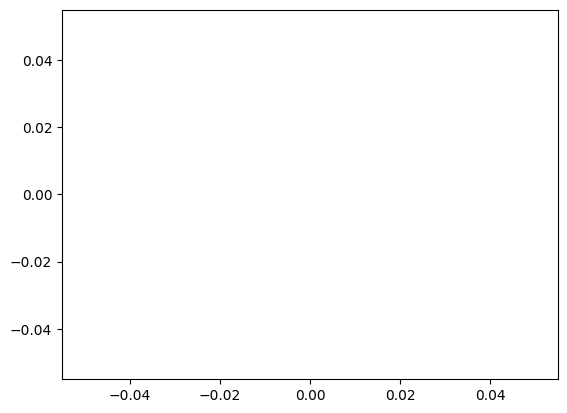

In [21]:
plt.plot(all_train_losses)

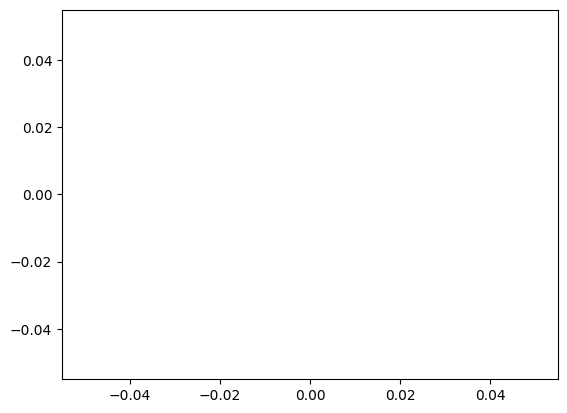

In [22]:
plt.plot(all_val_losses)

In [23]:
!wget https://cdn.pixabay.com/photo/2018/09/18/21/08/couple-3687274_960_720.jpg

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [24]:
model.eval()
img = Image.open("/kaggle/working/couple-3687274_960_720.jpg")
transform = T.ToTensor()
ig = transform(img)
with torch.no_grad():
    pred = model([ig.to(device)])

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/couple-3687274_960_720.jpg'

In [25]:
img

{'id': 9,
 'license': 1,
 'file_name': '56_jpg.rf.2041cebead8c51fe6bfcc639308eeec6.jpg',
 'height': 640,
 'width': 640,
 'date_captured': '2023-08-27T10:56:23+00:00'}

In [26]:
pred

NameError: name 'pred' is not defined

In [27]:
plt.imshow((pred[0]["masks"][0].cpu().detach().numpy() * 255).astype("uint8").squeeze())

NameError: name 'pred' is not defined